In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from cmb.configs.experiments import Configs
from cmb.datasets.jetclass import JetsBoundaryData
from cmb.dynamics.cfm import ConditionalFlowMatching

config = Configs('epic_hybrid.yaml')
jets = JetsBoundaryData(config=config.data, standardize=False)


2024-09-26 09:41:13.139753: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-26 09:41:13.259653: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-26 09:41:13.260809: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-26 09:41:14.146959: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## JetClass data

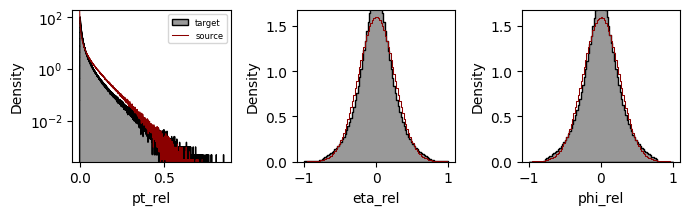

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(7,2.25))
jets.target.histplot('pt_rel', ax=ax[0], stat='density', log_scale=(False,True), color='k', alpha=0.4, label='target')
jets.source.histplot('pt_rel', ax=ax[0], stat='density',  log_scale=(False,True), color='darkred', fill=False, lw=0.75, label='source')
jets.source.histplot('eta_rel', binrange=(-1,1), binwidth=0.02, ax=ax[1], stat='density',  color='darkred', fill=False, lw=0.75, label='source')
jets.target.histplot('eta_rel', binrange=(-1,1), binwidth=0.02,ax=ax[1], stat='density',  color='k', alpha=0.4, label='target')
jets.source.histplot('phi_rel', binrange=(-1,1), binwidth=0.02,ax=ax[2], stat='density',  color='darkred', fill=False, lw=0.75, label='source')
jets.target.histplot('phi_rel', binrange=(-1,1), binwidth=0.02, ax=ax[2], stat='density', color='k', alpha=0.4, label='target')
ax[0].legend(fontsize=6)
plt.tight_layout()
plt.show()

(None, None)

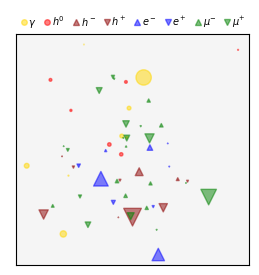

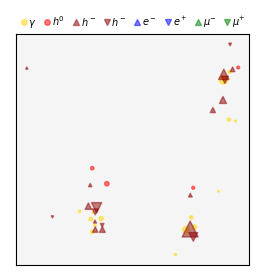

In [3]:
jets.source.display_cloud(idx=10,  scale_marker=200.0), jets.target.display_cloud(idx=10,  scale_marker=200.0)


In [4]:
jets.source.multiplicity.shape

torch.Size([300000])

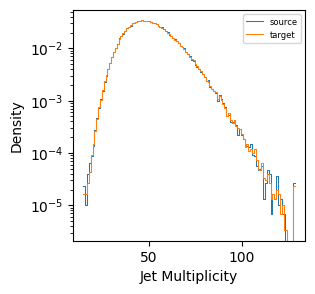

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.histplot(jets.source.multiplicity, element="step", fill=False, discrete=True, lw=0.75, stat='density', log_scale=(False, True),  ax=ax, label='source')
sns.histplot(jets.target.multiplicity, element="step", fill=False, discrete=True, lw=0.75, stat='density', log_scale=(False, True),  ax=ax, label='target')
ax.legend(fontsize=6)
ax.set_xlabel('Jet Multiplicity')
plt.show()

## Train CMB

In [2]:
from cmb.models.trainers import CMBTrainer
from cmb.models.architectures.epic import HybridEPiC
from cmb.dynamics.cmb import ConditionalMarkovBridge, BatchOTCMB

config.train.device = 'cuda:2'
config.model.num_blocks = 8
config.model.dim.embed.time = 32
config.model.dim.embed.features.continuous = 32
config.model.dim.embed.features.discrete = 32

epic = HybridEPiC(config)
dynamics = BatchOTCMB(config)
epic_cmb = CMBTrainer(config, dynamics, epic, jets)

epic_cmb.load(path='/home/df630/CMB/results/JetClass/beta-gauss_to_tops_ConditionalFlowMatching_HybridEPiC_2024.09.26_02h15', model='best')
# epic_cmb.train()


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.9/0.1/0.0
INFO: train size: 90000, validation size: 10000, testing sizes: 0


## Generate data

In [3]:
from cmb.models.pipelines import Pipeline

pipeline = Pipeline(config=config, trained_model=epic_cmb, dynamics=dynamics)

config.data.source.num_jets = 2500
config.data.target.path = ['/home/df630/CMB/data/JetClass/TTBar_002.root']
test = JetsBoundaryData(config.data)

pipeline.generate_samples(source_continuous=testsource.continuous, 
                          source_discrete=torch.tensor(test.source.discrete),
                          mask=test.source.mask)


/tmp/ipykernel_2356739/2682221718.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  source_discrete=torch.tensor(test_data.source.discrete),


RuntimeError: CUDA out of memory. Tried to allocate 4.58 GiB (GPU 2; 10.91 GiB total capacity; 5.17 GiB already allocated; 3.73 GiB free; 5.18 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [17]:
from cmb.datasets.jetclass import ParticleClouds

jets_generated = torch.cat([pipeline.paths[-1], pipeline.jumps[-1].unsqueeze(-1), test_data.source.mask], dim=-1)
jets_generated = ParticleClouds(jets_generated, min_num_particles=0, max_num_particles=128, discrete_features=True) 

mask_gen = jets_generated.mask > 0
mask_data = jets.target.mask > 0


## Plot results

In [20]:
args_gen = {'stat':'density', 'log_scale':(False, True), 'fill':False, 'color':'darkred', 'lw':0.75, 'label':'generated'}
args_tar = {'stat':'density', 'log_scale':(False, True), 'fill':True, 'color':'k','lw':0.3, 'alpha':0.3, 'label':'target'}

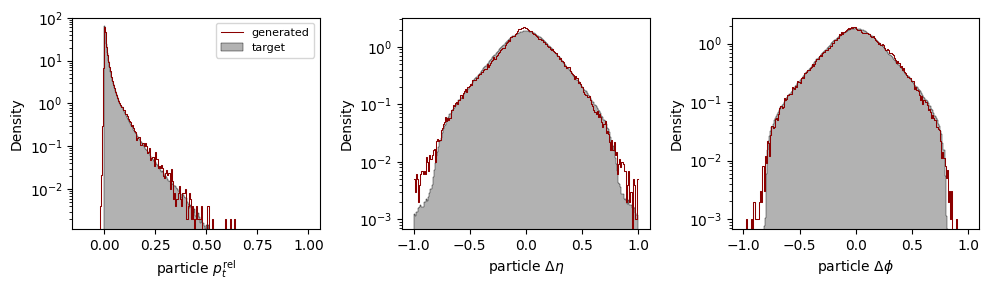

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(10,3))

jets_generated.histplot('pt_rel', binrange=(-.1, 1), binwidth=0.005, xlabel=r'particle $p_t^{\rm rel}$', ax=ax[0], **args_gen)
jets.target.histplot('pt_rel', binrange=(-.1, 1), binwidth=0.005, xlabel=r'particle $p_t^{\rm rel}$',ax=ax[0], **args_tar)

jets_generated.histplot('eta_rel', binrange=(-1, 1), binwidth=0.01, xlabel=r'particle $\Delta \eta$', ax=ax[1], **args_gen)
jets.target.histplot('eta_rel', binrange=(-1, 1), binwidth=0.01, xlabel=r'particle $\Delta \eta$', ax=ax[1],  **args_tar)

jets_generated.histplot('phi_rel', binrange=(-1, 1), binwidth=0.01, xlabel=r'particle $\Delta \phi$', ax=ax[2], **args_gen)
jets.target.histplot('phi_rel',binrange=(-1, 1), binwidth=0.01, xlabel=r'particle $\Delta \phi$', ax=ax[2],  **args_tar)

ax[0].legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'particle_distributions.png')
plt.show()

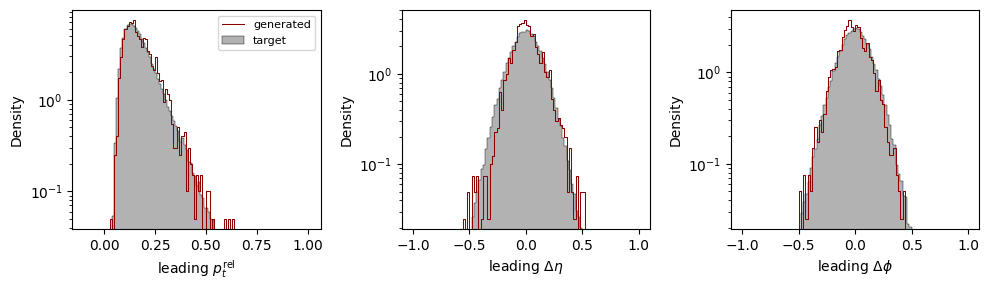

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(10,3))

jets_generated.histplot('pt_rel', idx=0, binrange=(-.1, 1), binwidth=0.01, xlabel=r'leading $p_t^{\rm rel}$', ax=ax[0], **args_gen)
jets.target.histplot('pt_rel', idx=0, binrange=(-.1, 1), binwidth=0.01, xlabel=r'leading $p_t^{\rm rel}$',ax=ax[0], **args_tar)

jets_generated.histplot('eta_rel', idx=0, binrange=(-1, 1), binwidth=0.02, xlabel=r'leading $\Delta \eta$', ax=ax[1], **args_gen)
jets.target.histplot('eta_rel', idx=0, binrange=(-1, 1), binwidth=0.02, xlabel=r'leading $\Delta \eta$', ax=ax[1],  **args_tar)

jets_generated.histplot('phi_rel', idx=0, binrange=(-1, 1), binwidth=0.02, xlabel=r'leading $\Delta \phi$', ax=ax[2], **args_gen)
jets.target.histplot('phi_rel', idx=0, binrange=(-1, 1), binwidth=0.02, xlabel=r'leading $\Delta \phi$', ax=ax[2],  **args_tar)

ax[0].legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'particle_leading_distributions.png')
plt.show()

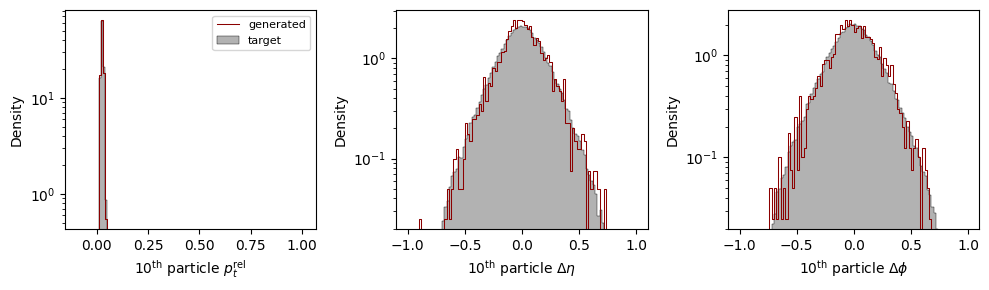

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(10,3))

jets_generated.histplot('pt_rel', idx=10, binrange=(-.1, 1), binwidth=0.01, xlabel=r'10$^{\rm th}$ particle $p_t^{\rm rel}$', ax=ax[0], **args_gen)
jets.target.histplot('pt_rel', idx=10, binrange=(-.1, 1), binwidth=0.01, xlabel=r'10$^{\rm th}$ particle $p_t^{\rm rel}$',ax=ax[0], **args_tar)

jets_generated.histplot('eta_rel', idx=10, binrange=(-1, 1), binwidth=0.02, xlabel=r'10$^{\rm th}$ particle$\Delta \eta$', ax=ax[1], **args_gen)
jets.target.histplot('eta_rel', idx=10, binrange=(-1, 1), binwidth=0.02, xlabel=r'10$^{\rm th}$ particle $\Delta \eta$', ax=ax[1],  **args_tar)

jets_generated.histplot('phi_rel', idx=10, binrange=(-1, 1), binwidth=0.02, xlabel=r'10$^{\rm th}$ particle $\Delta \phi$', ax=ax[2], **args_gen)
jets.target.histplot('phi_rel', idx=10, binrange=(-1, 1), binwidth=0.02, xlabel=r'10$^{\rm th}$ particle $\Delta \phi$', ax=ax[2],  **args_tar)

ax[0].legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'particle_subleading_distributions.png')
plt.show()

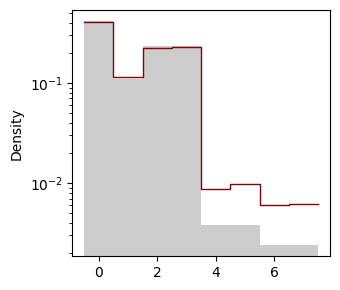

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(3.5,3))
sns.histplot(jets.target.discrete[mask_data.squeeze(-1)], discrete=True, **args_tar)
sns.histplot(jets_generated.discrete[mask_gen.squeeze(-1)], discrete=True, **args_gen)
plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'flavor_fraction.png')
plt.show()

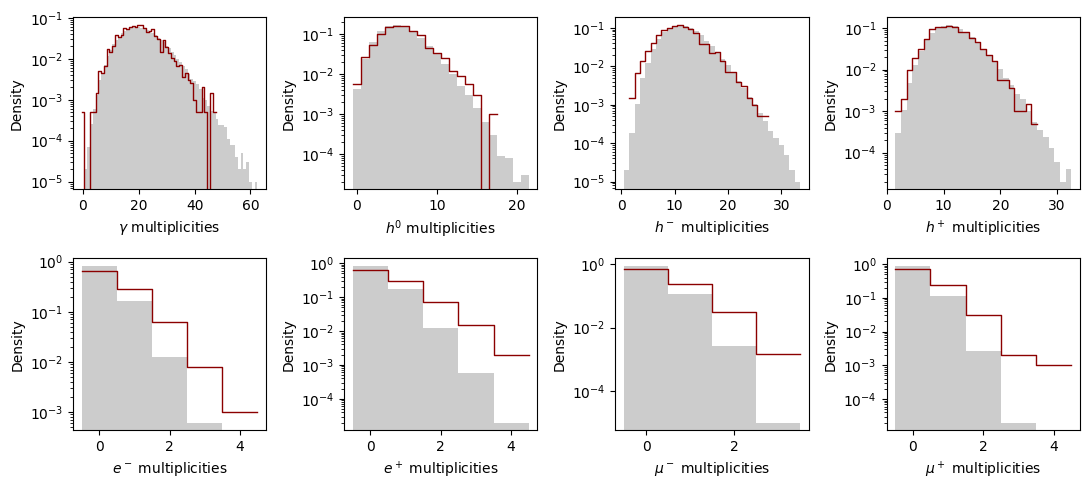

In [9]:
fig, ax = plt.subplots(2, 4, figsize=(11,5))

dic = {0:r'$\gamma$', 1:r'$h^0$', 2:r'$h^-$', 3:r'$h^+$', 4:r'$e^-$', 5:r'$e^+$', 6:r'$\mu^-$', 7:r'$\mu^+$'}

for n in [0,1,2,3]:
    gen_counts = (jets_generated.discrete == n) * mask_gen.squeeze(-1) 
    gen_counts = gen_counts.sum(dim=1)
    data_counts = (jets.target.discrete== n) * mask_data.squeeze(-1)
    data_counts = data_counts.sum(dim=1)
    
    sns.histplot(data_counts , discrete=True, element='step', alpha=0.2, lw=0., color='k', label='target', stat='density', log_scale=(False, True), ax=ax[0,n])
    sns.histplot(gen_counts, discrete=True, element='step', fill=False, color='darkred', lw=1,label='generated', stat='density', log_scale=(False, True), ax=ax[0,n])
    ax[0,n].set_xlabel(f'{dic[n]} multiplicities')
for n in [0,1,2,3]:
    gen_counts = (jets_generated.discrete == 4+n).sum(dim=1)
    data_counts = (jets.target.discrete== 4+n).sum(dim=1)
    sns.histplot(data_counts , discrete=True, element='step', alpha=0.2, lw=0., color='k', label='target', stat='density', log_scale=(False, True), ax=ax[1,n])
    sns.histplot(gen_counts, discrete=True, element='step', fill=False, color='darkred', lw=1,label='generated', stat='density', log_scale=(False, True), ax=ax[1,n])
    ax[1,n].set_xlabel(f'{dic[4+n]} multiplicities')

plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'flavor_fraction.png')
plt.show()

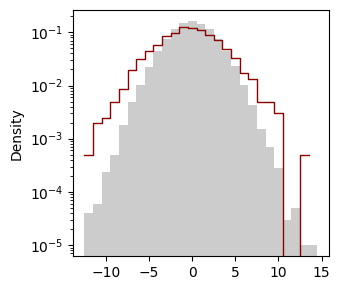

In [15]:
gen_total_charge = (jets_generated.discrete == 2).sum(dim=1) - (jets_generated.discrete == 3).sum(dim=1) + (jets_generated.discrete == 4).sum(dim=1) - (jets_generated.discrete == 5).sum(dim=1) + (jets_generated.discrete == 6).sum(dim=1) - (jets_generated.discrete == 7).sum(dim=1)
data_total_charge = (jets.target.discrete == 2).sum(dim=1) - (jets.target.discrete == 3).sum(dim=1) + (jets.target.discrete == 4).sum(dim=1) - (jets.target.discrete == 5).sum(dim=1) + (jets.target.discrete == 6).sum(dim=1) - (jets.target.discrete == 7).sum(dim=1)

fig, ax = plt.subplots(1, 1, figsize=(3.5,3))
sns.histplot(gen_total_charge, discrete=True, element='step', fill=False, color='darkred', lw=1,label='generated', stat='density', log_scale=(False, True))
sns.histplot(data_total_charge, discrete=True, element='step', alpha=0.2, lw=0., color='k', label='target', stat='density', log_scale=(False, True))
plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'jet_charge.png')
plt.show()


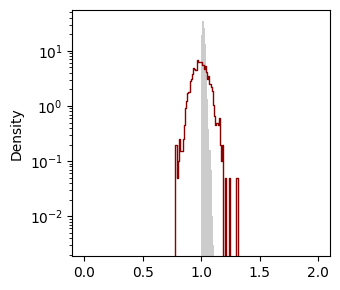

In [16]:
gen_jet_pt = jets_generated.continuous[...,0].sum(dim=1)
data_jet_pt = jets.target.continuous[...,0].sum(dim=1)

fig, ax = plt.subplots(1, 1, figsize=(3.5,3))
sns.histplot(gen_jet_pt, binrange=(0., 2), binwidth=0.01, element='step', fill=False, color='darkred', lw=1,label='generated', stat='density', log_scale=(False, True))
sns.histplot(data_jet_pt, binrange=(0., 2), binwidth=0.01, element='step', alpha=0.2, lw=0., color='k', label='target', stat='density', log_scale=(False, True))
plt.tight_layout()
plt.savefig(epic_cmb.workdir / 'jet_pt.png')
plt.show()